# Tema 4: Logging & Inference

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

### 1. Seleccionar GPU

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## 2. Conectar con Google Drive

Para poder guardar los modelos.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Crear el dataset y dataloader para el conjunto de Fashion MNIST.

### Función Transform

In [ ]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Redimensionar imágenes

    transforms.ToTensor(),  # Convertir a tensor
    Lambda(lambda x: x / 255.0)  # Normalización

])

### Dataset

In [ ]:
full_train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

### Dividir el conjunto de train, entre train y validación (80 y 20% respectivamente).

Para ello utilizar ***random_split*** de torch.

In [ ]:
train_size = int(0.8 * len(full_train_dataset))  # 80% para entrenamiento
val_size = len(full_train_dataset) - train_size  # 20% para validación

In [ ]:
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

### Crear una función collate que aplane las muestras y devuelva por separado las muestras y las etiquetas.

In [ ]:
def flatten_batch(data):

    images_collate = torch.stack([item[0] for item in data])
    labels_collate = torch.tensor([item[1] for item in data])

    # Aplanar las imágenes (batch_size, 28*28)
    images = images_collate.view(images_collate.size(0), -1)
    return images, labels_collate

### Crear el Dataloader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=flatten_batch)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=flatten_batch)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=flatten_batch)

## 4. Crear el modelo de MLP

Se puede utilizar la clase que hemos creado en otras sesiones de la asignatura.

In [ ]:
class MLP_pytorch(nn.Module):
    def __init__(self, input_shape=150*150, n_classes=10):
        super().__init__()
        self.input_shape = input_shape
        self.n_classes = n_classes


        self.l1 = nn.Linear(self.input_shape, 64)
        self.l2 = nn.Linear(64, 128)
        self.l3 = nn.Linear(128, self.n_classes)
        self.act = nn.ReLU()

    def forward(self, x):
        # Forward pass
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        x = self.act(x)
        x = self.l3(x)
        return x

### Crear una instancia del modelo y pasarlo a GPU

In [ ]:
model = MLP_pytorch().to(device)

## 5. Crear las funciones para:

* model_checkpoint: que guarde el mejor modelo, utilizando el loss de validación.
* plot_progress: una función que en cada época guarde una visualización con las gráficas de loss y accuracy para entrenamiento y validación. Guardalo en PDF.
* Guardar el loss y el accuracy de cada época en un archivo csv.

In [ ]:
def model_checkpoint(val_loss,epoch,model,optimizer,checkpoint_path,best_model_path):
      torch.save(model, best_model_path)  # Guarda el modelo

      torch.save({
          'epoch': epoch,  # Número de épocas completadas
          'model_state_dict': model.state_dict(),  # Estado del modelo
          'optimizer_state_dict': optimizer.state_dict(),  # Estado del optimizador
          'loss': val_loss  # Última pérdida registrada (opcional)
      }, f"{checkpoint_path}")
      print(f"Modelo guardado en {checkpoint_path} con pérdida de validación: {best_val_loss:.4f}")

def plot_progress(train_loss_history,val_loss_history,train_acc_history,val_acc_history,plot_path):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    epochs_ = list(range(len(train_loss_history)))
    # Plot 1: Loss
    axes[0].plot(epochs_, train_loss_history, label=f'Train Loss: {train_loss_history[-1]:.4f}', marker='')
    axes[0].plot(epochs_, val_loss_history, label=f'Validation Loss: {val_loss_history[-1]:.4f}', marker='')
    axes[0].set_title("Training and Validation Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    # Plot 2: Accuracy
    axes[1].plot(epochs_, train_acc_history, label=f'Train Accuracy: {train_acc_history[-1]:.3f}', marker='')
    axes[1].plot(epochs_, val_acc_history, label=f'Validation Accuracy: {val_acc_history[-1]:.3f}', marker='')
    axes[1].set_title("Training and Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    # Ajustar el diseño y guardar como PDF
    plt.tight_layout()
    plt.savefig(plot_path, format="pdf")
    plt.close(fig)


def save_results(epoch,train_loss,train_acc,val_loss,val_acc,csv_path):
    header = "epoch,train_loss,train_acc,val_loss,val_acc\n"
    data = f"{epoch},{train_loss},{train_acc},{val_loss},{val_acc}\n"

    file_exists = os.path.exists(csv_path)

    with open(csv_path, mode='a') as file:
        if not file_exists or os.stat(csv_path).st_size == 0:
            file.write(header)
        file.write(data)

## 6. Entrenar el modelo.

Definir todas las variables necesarias para:

* Que se guarden en un directorio "results":
  * el mejor modelo basandose en el loss.
  * el checkpoint del modelo: época, model_state_dict, optimizer_state_dict y loss
  * el plot del entrenamiento.
  * el loss y el accuracy de train y validación en un csv.

* Crea una condición de detención temprana, en la que si durante 3 épocas consecutivas no mejora 0,005 el modelo (utilizando el loss) pare el entrenamiento.
* lr = 0.001
* Número de épocas = 5
* Optimizador = Adam

In [ ]:
model = MLP_pytorch().to(device)
epochs = 5
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

path = "PATH"

# EarlyStopping
val_loss_history = []
patience = 3
min_delta = 0.005
early_stop_counter = 0

# Training progress Visualization
plot_namefile = "training_plot.pdf"
plot_path = path+plot_namefile
train_loss_history = []
train_acc_history = []
val_acc_history = []

# Save results as csv
csv_file = "training_results.csv"
csv_path = path+csv_file

# Model checkpoint
best_model_namefile = "best_model.pth"
best_model_path = path+best_model_namefile

checkpoint_namefile = "checkpoint.pth"
checkpoint_path = path+checkpoint_namefile
best_val_loss = float('inf')

### Bucle de entrenamiento

In [ ]:
for epoch in range(epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)


    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_checkpoint(val_loss,epoch,model,optimizer,checkpoint_path,best_model_path)

    plot_progress(train_loss_history,val_loss_history,train_acc_history,val_acc_history,plot_path)

    save_results(epoch,train_loss,train_acc,val_loss,val_acc,csv_path)

    if epoch >= 1:
      improvement = val_loss_history[-2] - val_loss_history[-1]
      if improvement > min_delta:
        best_val_loss = val_loss
        early_stop_counter = 0
      else:
        early_stop_counter += 1  # Incrementa el contador si no mejora
        print(f"No mejora suficiente en la pérdida de validación por {early_stop_counter} época(s).")
      if early_stop_counter == patience:
        break

Época 1/5 | Train Loss: 0.8317, Train Acc: 0.69% | Val Loss: 0.5653, Val Acc: 0.79%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/results/checkpoint.pth con pérdida de validación: 0.5653
Época 2/5 | Train Loss: 0.5269, Train Acc: 0.81% | Val Loss: 0.4921, Val Acc: 0.82%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/results/checkpoint.pth con pérdida de validación: 0.4921
Época 3/5 | Train Loss: 0.4689, Train Acc: 0.83% | Val Loss: 0.4600, Val Acc: 0.84%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/results/checkpoint.pth con pérdida de validación: 0.4600
Época 4/5 | Train Loss: 0.4355, Train Acc: 0.85% | Val Loss: 0.4257, Val Acc: 0.85%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/results/checkpoint.pth con pérdida de validación: 0.4257
Época 5/5 | Train Loss: 0.4127, Train Acc: 0.85% | Val L

## 7. Cargar el modelo y el checkpoint

In [ ]:
model_complete = torch.load(best_model_path, weights_only=False)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Usa el mismo optimizador

# Cargar el checkpoint
checkpoint = torch.load(checkpoint_path)
model_complete.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

<ipython-input-43-a5648f62d148>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


## 8. Reentrenar el modelo

Reentrenar durante 20 épocas, con las mismas condiciones que en el primer entrenamiento.

In [ ]:
epochs = 20
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/results_2/"
model = model_complete


# EarlyStopping
val_loss_history = []
patience = 3
min_delta = 0.005
early_stop_counter = 0

# Training progress Visualization
plot_namefile = "training_plot.pdf"
plot_path = path+plot_namefile
train_loss_history = []
train_acc_history = []
val_acc_history = []

# Save results as csv
csv_file = "training_results.csv"
csv_path = path+csv_file

# Model checkpoint
best_model_namefile = "best_model.pth"
best_model_path = path+best_model_namefile

checkpoint_namefile = "checkpoint.pth"
checkpoint_path = path+checkpoint_namefile
best_val_loss = float('inf')

In [ ]:
for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reinicia los gradientes
        outputs = model(images)  # Predicción
        loss = criterion(outputs, labels)  # Cálculo de la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualización de los pesos

        running_loss += loss.item()

        # Precisión durante el entrenamiento
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # --- Validación ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_loss = val_loss / len(val_loader)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)


    print(f"Época {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_checkpoint(val_loss,epoch,model,optimizer,checkpoint_path,best_model_path)

    plot_progress(train_loss_history,val_loss_history,train_acc_history,val_acc_history,plot_path)


    save_results(epoch,train_loss,train_acc,val_loss,val_acc,csv_path)

    if epoch >= 1:
      improvement = val_loss_history[-2] - val_loss_history[-1]
      if improvement > min_delta:
        best_val_loss = val_loss
        early_stop_counter = 0
      else:
        early_stop_counter += 1  # Incrementa el contador si no mejora
        print(f"No mejora suficiente en la pérdida de validación por {early_stop_counter} época(s).")
      if early_stop_counter == patience:
        break

Época 1/20 | Train Loss: 0.3959, Train Acc: 0.86% | Val Loss: 0.4086, Val Acc: 0.86%
Modelo guardado en /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema4/results_2/checkpoint.pth con pérdida de validación: 0.4086
Época 2/20 | Train Loss: 0.3959, Train Acc: 0.86% | Val Loss: 0.4086, Val Acc: 0.86%
No mejora suficiente en la pérdida de validación por 1 época(s).
Época 3/20 | Train Loss: 0.3959, Train Acc: 0.86% | Val Loss: 0.4086, Val Acc: 0.86%
No mejora suficiente en la pérdida de validación por 2 época(s).
Época 4/20 | Train Loss: 0.3959, Train Acc: 0.86% | Val Loss: 0.4086, Val Acc: 0.86%
No mejora suficiente en la pérdida de validación por 3 época(s).


## 9. Evaluar el modelo con el conjunto de Test.

Calcular el loss y el accuracy.
Guardar en listas:
* Etiquetas
* Predicciones
* Probabilidades

In [ ]:
model.eval()

# Evaluación del modelo
total_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []
all_probabilities = []


with torch.no_grad():  # No calcular gradientes
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Mover a GPU si está disponible

        # Adelante
        outputs = model(inputs.view(inputs.size(0), -1))  # Aplanar si usas una MLP
        loss = criterion(outputs, labels)
        probabilities = torch.softmax(outputs, dim=1)  # Obtener probabilidades
        _, predicted = torch.max(outputs, 1)  # Predicciones de clase

        # Acumular la pérdida
        total_loss += loss.item()

        # Calcular predicciones correctas
        _, predicted = torch.max(outputs, 1)  # Clase con mayor probabilidad
        correct += (predicted == labels).sum().item()
        total += labels.size(0)


        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())


# Cálculo de métricas
avg_loss = total_loss / len(test_loader)
accuracy = correct / total

print(f"Pérdida promedio en test: {avg_loss:.4f}")
print(f"Precisión en test: {accuracy:.4%}")
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

Pérdida promedio en test: 0.4349
Precisión en test: 84.3700%


## 10. Inferencia

Muestra las predicciones para 5 muestras para cada bach, durante 6 iteraciones.

Tener en cuenta que tendréis que modificar la forma de las muestras.

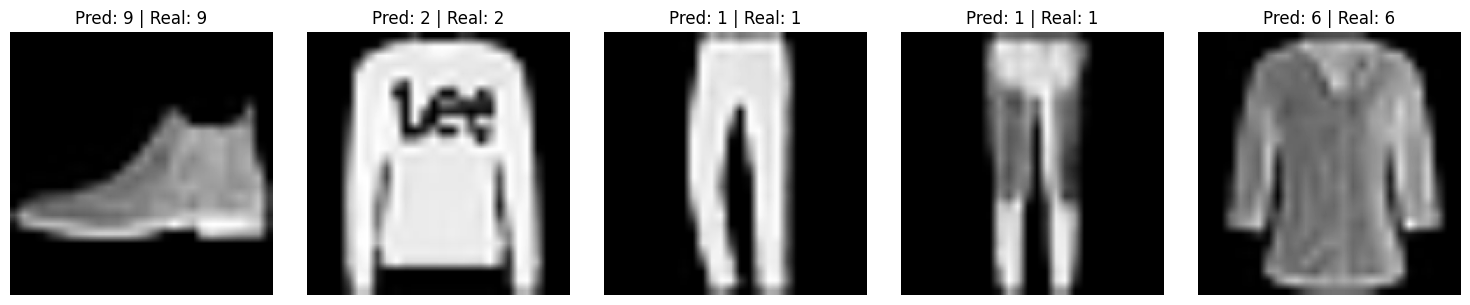

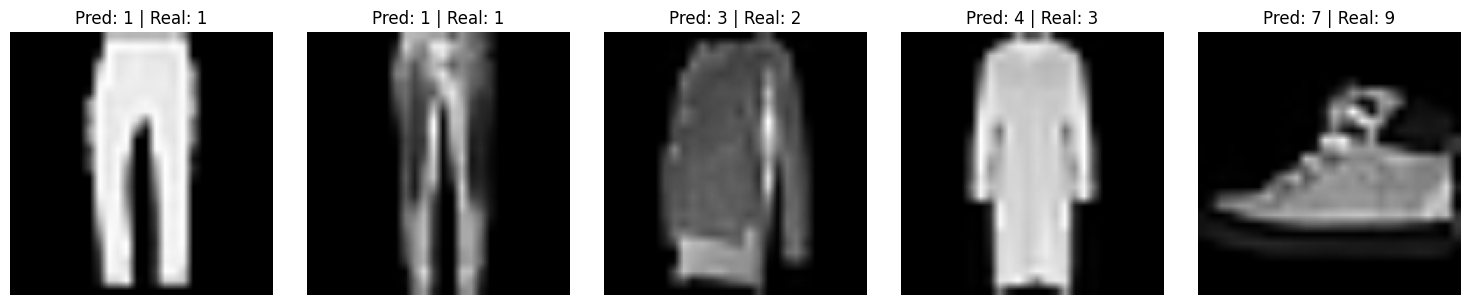

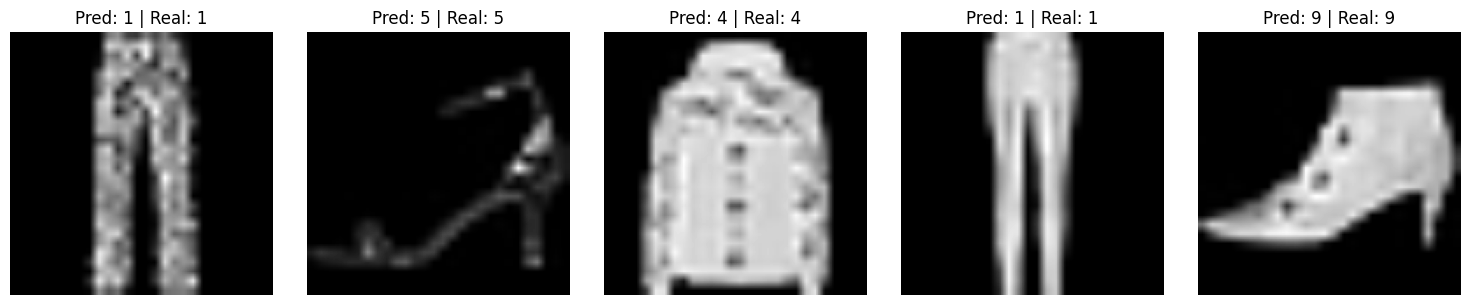

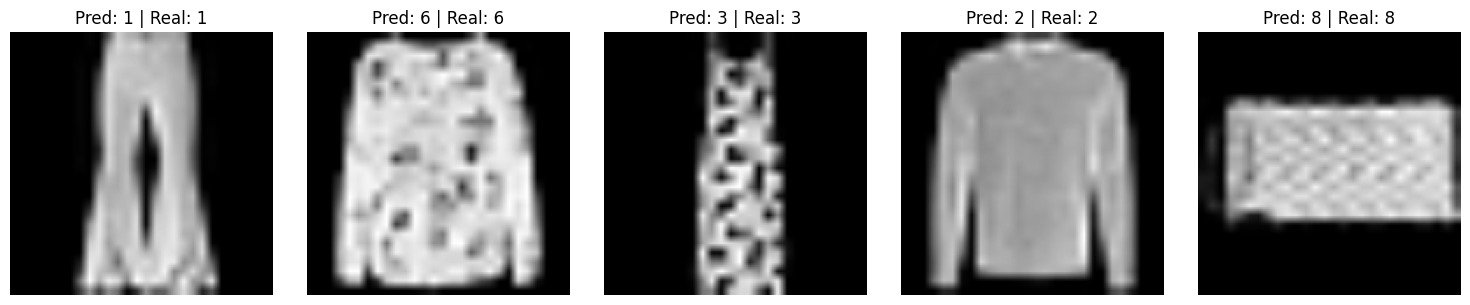

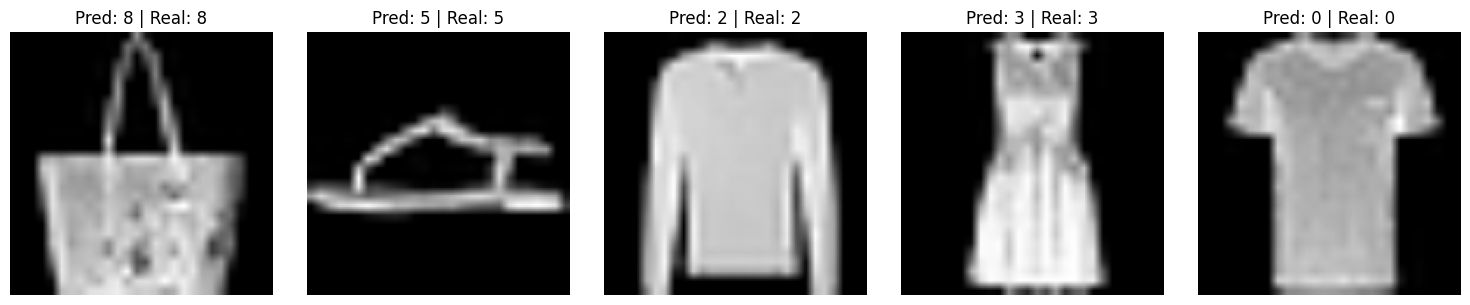

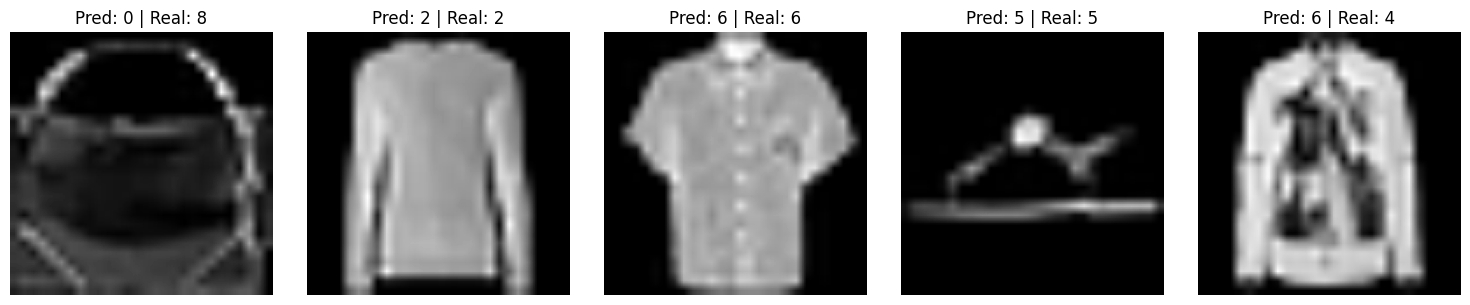

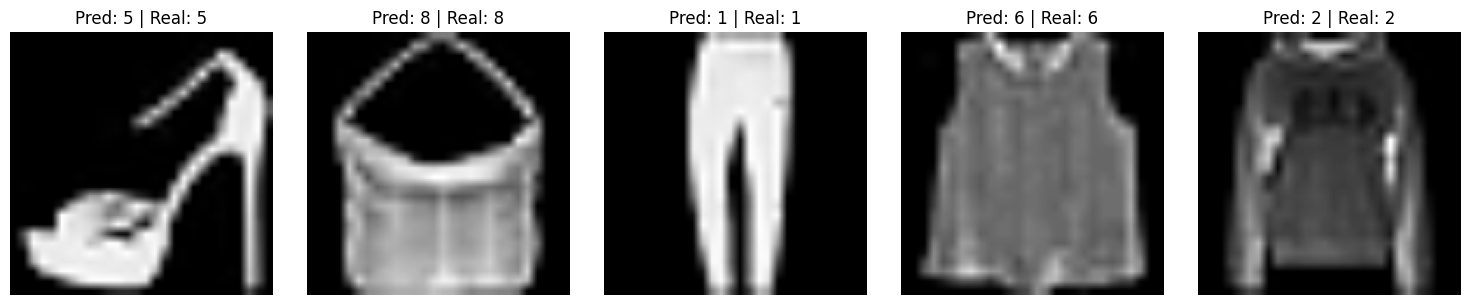

In [ ]:
image_shape = (150, 150)

model.eval()
with torch.no_grad():
    for j, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)


        total_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for i, (img, pred, target) in enumerate(zip(inputs, predicted, labels)):
            if i >= 5:
                break


            img = img.view(image_shape).cpu()


            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Pred: {pred.item()} | Real: {target.item()}")
            axes[i].axis('off')


        plt.tight_layout()
        plt.show()
        if j == 6:
          break

## 11. Métricas

### Reporte de clasificación de Sklearn

In [ ]:
print("Reporte de Clasificación:\n")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

Reporte de Clasificación:

              precision    recall  f1-score   support

 T-shirt/top       0.79      0.85      0.82      1000
     Trouser       0.99      0.94      0.97      1000
    Pullover       0.77      0.68      0.72      1000
       Dress       0.86      0.84      0.85      1000
        Coat       0.68      0.82      0.74      1000
      Sandal       0.93      0.93      0.93      1000
       Shirt       0.63      0.54      0.58      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.93      0.96      0.95      1000
  Ankle boot       0.96      0.93      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



### Matriz de confusión

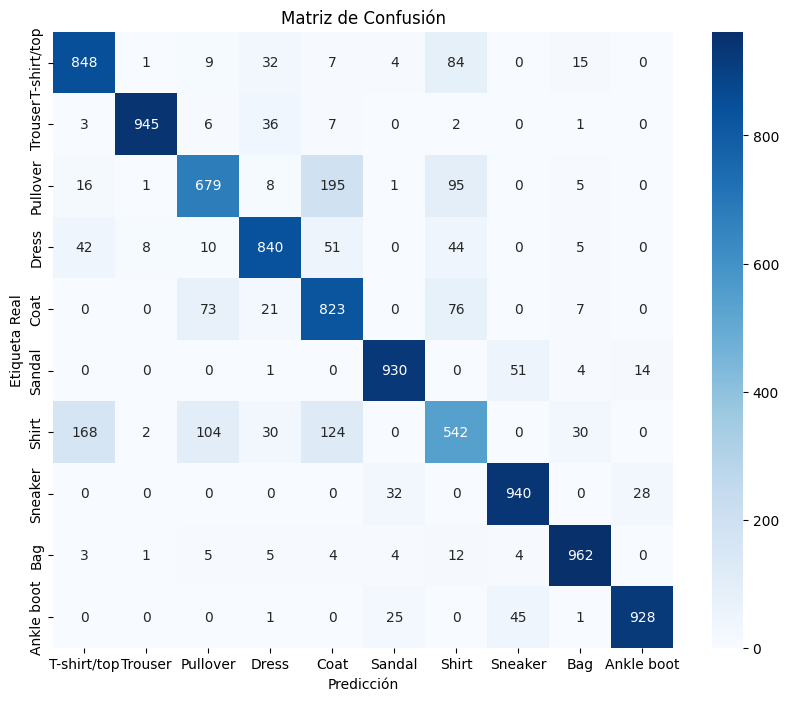

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

### Curva Roc global

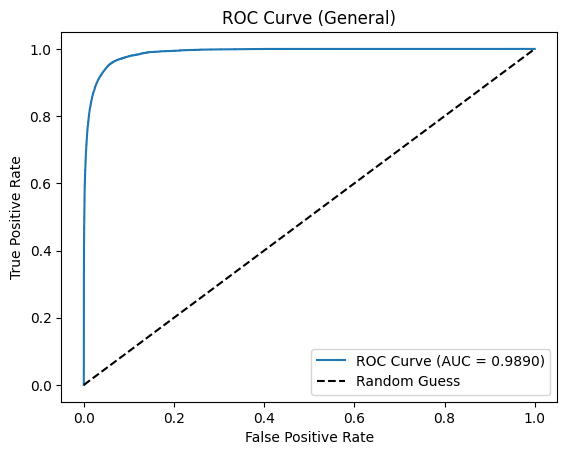

In [ ]:
classes = np.unique(all_labels)
y_true_bin = label_binarize(all_labels, classes=classes)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular la curva ROC macro promedio
fpr["macro"], tpr["macro"], _ = roc_curve(y_true_bin.ravel(), all_probabilities.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label=f'ROC Curve (AUC = {roc_auc["macro"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (General)')
plt.legend(loc="lower right")
plt.show()

### Curva Roc por clases

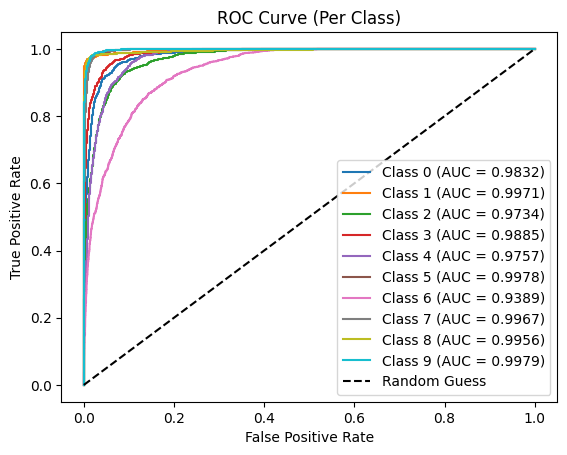

In [ ]:
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_name} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Per Class)')
plt.legend(loc="lower right")
plt.show()